# Starbucks Capstone Challenge

## Preprocess data

In [1]:
import pandas as pd
import numpy as np
import math
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import random
from functools import reduce

sns.set_theme(style="whitegrid")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
%matplotlib inline

# read in the json files
portfolio = pd.read_json('./data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('./data/profile.json', orient='records', lines=True)
transcript = pd.read_json('./data/transcript.json', orient='records', lines=True)

### portfolio

In [2]:
portfolio.shape

(10, 6)

In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
portfolio.sort_values(by=['offer_type','duration','difficulty'], ignore_index=True, inplace=True)
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
4,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
5,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
8,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
9,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


In [5]:
# simplify offer_id
portfolio['offer_id'] = portfolio['offer_type'].str.get(0)+portfolio.index.astype(str)
offer_id_dict = dict(zip(portfolio.id,portfolio.offer_id))
del portfolio['id']

# split channels column
portfolio_explode = portfolio.explode('channels')
portfolio_channels = pd.get_dummies(portfolio_explode.channels, prefix='channels')
grouped_channels = portfolio_channels.groupby(portfolio_channels.index)[portfolio_channels.columns].sum()
portfolio = portfolio.join(grouped_channels, how='left').drop('channels', axis=1)

# change measurement of duration from day to hour
portfolio['duration_h'] = portfolio['duration'] * 24
del portfolio['duration']

portfolio

,reward,difficulty,offer_type,offer_id,channels_email,channels_mobile,channels_social,channels_web,duration_h
0,5,5,bogo,b0,1,1,1,1,120
1,10,10,bogo,b1,1,1,1,1,120
2,5,5,bogo,b2,1,1,0,1,168
3,10,10,bogo,b3,1,1,1,0,168
4,3,7,discount,d4,1,1,1,1,168
5,2,10,discount,d5,1,1,0,1,168
6,2,10,discount,d6,1,1,1,1,240
7,5,20,discount,d7,1,0,0,1,240
8,0,0,informational,i8,1,1,1,0,72
9,0,0,informational,i9,1,1,0,1,96


### profile

In [6]:
profile.shape

(17000, 5)

In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


- value None in gender column is same as NaN in income column
- age 118 is nearly impossible, so I might treat it as unknown value as well
- values in became_member_on column should be datetime type

#### gender

In [9]:
profile.gender.value_counts(dropna=False, normalize=True)

M      0.499059
F      0.360529
NaN    0.127941
O      0.012471
Name: gender, dtype: float64

In [10]:
# change dtype of gender from string to integer by
# Male->1
# Female->2
# Other->3
# unknown->4
profile.gender.replace({'M':1, 'F':2, 'O':3, np.nan:4}, inplace=True)

profile.gender.head()

0    4
1    2
2    4
3    2
4    4
Name: gender, dtype: int64

#### age

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

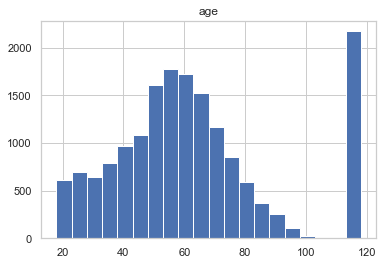

In [11]:
profile.hist('age', bins=20)
profile['age'].describe()

- minimum age is 18, which might be because this program is available only for adults
- more than 12% of people are at age 118, which is definitely impossible, so I guess it can be treated as NaN values

In [12]:
profile['is_mysterious'] = np.where((profile.age==118)&(profile.gender==4)&(profile.income.isnull()),1,0)
profile['is_mysterious'].value_counts()

0    14825
1     2175
Name: is_mysterious, dtype: int64

In [13]:
# change age of 118 to NaN
profile['age'] = np.where(profile['age'] == 118, np.nan, profile['age'])

In [14]:
# cut age into 4 bins
profile['age_bin'] = pd.cut(x=profile['age'], bins=[profile['age'].min(), 30, 50, 70, profile['age'].max()])

profile['age_bin'].value_counts()

(50.0, 70.0]     6500
(30.0, 50.0]     3988
(70.0, 101.0]    2632
(18.0, 30.0]     1635
Name: age_bin, dtype: int64

#### id

In [15]:
# rename id as member id
profile.rename(columns={'id':'member_id'}, inplace=True)

#### became_member_on

In [16]:
# change data type of became_member_on column from string to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d', errors='ignore')

profile['became_member_on'].max()

Timestamp('2018-07-26 00:00:00')

the last person who enrolled in this program is on July 26th, 2018

In [17]:
# split into year, month, and day
profile['enrolled year'] = profile['became_member_on'].dt.year
profile['enrolled month'] = profile['became_member_on'].dt.month
profile['enrolled day'] = profile['became_member_on'].dt.day

In [18]:
# add a column calculating membership days of each customer
lastday = profile['became_member_on'].max()
profile['membership_days'] = profile['became_member_on'].apply(lambda x: (lastday - x).days + 24)

# add a column calculating membership months of each customer
profile['membership_months'] = profile['membership_days'].map(lambda x: int(x/30))

# delete became_member_on column
del profile['became_member_on']

#### income

In [19]:
# qcut income into 4 bins
profile['income_bin'] = pd.qcut(x=profile['income'], q=4)

profile['income_bin'].value_counts()

(49000.0, 64000.0]      3863
(29999.999, 49000.0]    3781
(64000.0, 80000.0]      3616
(80000.0, 120000.0]     3565
Name: income_bin, dtype: int64

### transcript

In [20]:
transcript.shape

(306534, 4)

In [21]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


- values of the person column seems to be the same as the id column of profile dataframe, if this is the case, then I will rename person as member_id. 
- the value column contains dictionaries, so I will separate it into two columns by key and value. 
- I have not idea what the values in the time column represent, and I guess it is the time when the event happend.

#### person

In [23]:
# change the column name from "person" to "member_id"
transcript.rename(columns={'person':'member_id'}, inplace=True)

#### event

In [24]:
transcript.event.value_counts(normalize=True)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

the reasonable order of events should be: offer received -> offer viewed -> offer completed, but other situationa may also happen. For example, someone might complete the offer without viewing it, or might view the offer after completing it. Therefore, we should take all situations into account.

#### value

In [25]:
transcript.value.sample(20)

66534                                                 {'amount': 29.36}
41330                                                 {'amount': 17.85}
125912                 {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
39352     {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}
117445                 {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
18621                                                 {'amount': 14.78}
191808                                                {'amount': 32.47}
42198                                                 {'amount': 13.36}
213                    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
16335                                                  {'amount': 6.91}
255134                 {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
201133                                                {'amount': 25.76}
151917                 {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
177125    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'rewa

the value column contains many information, including transaction amount, offer id, and reward amount, so it might be better to extract those information and put them into separate columns

In [26]:
# split value column
transcript_value = pd.DataFrame(transcript['value'].values.tolist(), index=transcript.index)
transcript = pd.concat([transcript.drop(['value'], axis=1), transcript_value], axis=1)
transcript.head()

,member_id,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [27]:
# keep offer_id column and fillna with values of offer id column and delete offer id column
transcript['offer_id'].fillna(transcript['offer id'], inplace=True)
del transcript['offer id']

# change offer_id to new_offer_id
transcript['offer_id'] = transcript['offer_id'].map(offer_id_dict)

transcript.head()

,member_id,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,b2,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,d5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,d6,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,b1,NaN


#### time

In [28]:
transcript['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [29]:
transcript['time'].max()/30

23.8

the records on this file lasts about 24 days

#### randomly select customers

In [30]:
random_person = random.choice(transcript['member_id'])
transcript[transcript['member_id']==random_person]

,member_id,event,time,amount,offer_id,reward
42978,d1b27128438f4fe58ec38cc066067c26,transaction,102,18.60,NaN,NaN
63021,d1b27128438f4fe58ec38cc066067c26,offer received,168,NaN,b1,NaN
71523,d1b27128438f4fe58ec38cc066067c26,offer viewed,174,NaN,b1,NaN
110622,d1b27128438f4fe58ec38cc066067c26,transaction,330,16.67,NaN,NaN
120667,d1b27128438f4fe58ec38cc066067c26,offer received,336,NaN,d4,NaN
129481,d1b27128438f4fe58ec38cc066067c26,offer viewed,342,NaN,d4,NaN
160480,d1b27128438f4fe58ec38cc066067c26,offer received,408,NaN,b0,NaN
211383,d1b27128438f4fe58ec38cc066067c26,offer received,504,NaN,i9,NaN
224391,d1b27128438f4fe58ec38cc066067c26,offer viewed,516,NaN,i9,NaN
254970,d1b27128438f4fe58ec38cc066067c26,offer received,576,NaN,i9,NaN


## **Feature Engineering**

## Create new features

By checking the information above, I will add several new features. Before that, I will rearange the dataframe by matching all actions by offer.

#### create a dataframe containning receive, view, and complete time of each offer

In [31]:
time_dict = {}
time_list = ['receive','view','complete']

# create 3 dataframes containing time of "offer received", "offer viewed", and "offer completed", and rename them as
# "receive_time", "view_time", and "complete_time"
for t in time_list:
    time_dict[t] = transcript[transcript['event'].str.contains(t)][['member_id','offer_id','time']]\
                    .rename(columns={'time':'%s_time'%t}).set_index(['member_id','offer_id'])

# combine the 3 dataframes with three new columns created above, so that each offer of each customer has receive time,
# view time, and complete time on the same row. Since the 3 dataframes are outer combined on member_id and offer_id,
# if the offer was received, or viewed, or completed more than one time, then all possible combinations will be
# created, so I have to find the correct match and delete the rest
time_df = reduce(lambda x,y: pd.merge(x,y, on=['member_id','offer_id'], how='outer'), 
                 list(time_dict.values())).reset_index()

# create a list to calculate the time difference between receiving&viewing, receivign&completing, and 
# viewing&completing of each offer
time_list2 = [['receive','view'],['receive','complete'],['view','complete']]

# create a column calculating differences of pairs listed above
# if any value of the pair is NaN then the difference is NaN otherwise calculate the difference
for t in time_list2:
    time_df['%s_%s_diff'%(t[0],t[1])] = time_df.apply(lambda x: np.nan if np.isnan(x['%s_time'%t[0]])
                                                                       or np.isnan(x['%s_time'%t[1]]) 
                                                                else x['%s_time'%t[1]] - x['%s_time'%t[0]], axis=1) 
    
    # if time difference of receive&view or receive%complete is negative, which means the offer was viewed or 
    # completed before it was received, then that is impossible and the view time or complete time is incorrect and 
    # should be NaN
    if t[0]=='receive': 
        time_df['%s_time'%t[1]] = np.where(time_df['receive_%s_diff'%t[1]]>=0, time_df['%s_time'%t[1]], np.nan)
        
        time_df['receive_%s_diff'%t[1]] = np.where(time_df['%s_time'%t[1]].isnull(), np.nan, time_df['receive_%s_diff'%t[1]])

# sort values so the smallest difference or non-NaN values will be on top
time_df.sort_values(by=['member_id','offer_id','receive_time','view_time','complete_time'], inplace=True)
# if duplicated values exist, then drop larger differences or NaN values
time_df.drop_duplicates(subset=['member_id','offer_id','receive_time'], keep='first', inplace=True)

# till now the receive time column is clean, but view and complete column still contain duplicated values. We cannot
# simply drop all duplicated values, because it is possible that more than one offer can be viewed or completed within
# one hour, and there are records with same member_id, offer_id, and view of complete time, which means that the
# customer received two offers of same offer_id in different times, but completed both of them in one hour or even in
# one trasaction
for i in ['view','complete']:
    # count how many of offers by type each members viewed or completed in the original dataframe, and get the time
    # for example, customer A completed offer 1 in time 10 twice, and customer B completed offer 2 in time 5 3 times
    view_df = transcript[transcript['event'].str.contains(i)]
    view_cnt_real = view_df.groupby(['member_id','offer_id','time']).size()\
                    .to_frame(name='real_%s'%i)\
                    .reset_index()\
                    .rename(columns={'time':'%s_time'%i})
    
    # merge the count dataframe into time_df, so we know how many duplicates are allowed for each offer of each 
    # customer at each view time or complete time
    time_df = time_df.merge(view_cnt_real, on=['member_id','offer_id','%s_time'%i], how='left')
    # create a rank column, ranking how many duplicates are there for each offer of each customer at each time, and
    # order by time difference between view/complete and receive. So if maximum of 2 duplicates is allowed, then keep
    # the 2 with shortest time difference, and change the view time or complete time of the rest to NaN
    time_df['%s_rank'%i] = time_df.groupby(['member_id','offer_id','%s_time'%i])['receive_%s_diff'%i].rank()
    time_df['%s_time'%i] = np.where(time_df['%s_rank'%i]<=time_df['real_%s'%i], time_df['%s_time'%i], np.nan)

time_group = time_df.loc[:,['member_id','offer_id','receive_time','view_time','complete_time'
                           ,'receive_view_diff','receive_complete_diff','view_complete_diff'
                            ]]

time_group = time_group.merge(portfolio, on='offer_id', how='left')

time_group.head()

,member_id,offer_id,receive_time,view_time,complete_time,receive_view_diff,receive_complete_diff,view_complete_diff,reward,difficulty,offer_type,channels_email,channels_mobile,channels_social,channels_web,duration_h
0,0009655768c64bdeb2e877511632db8f,b0,408,456.0,414.0,48.0,6.0,-42.0,5,5,bogo,1,1,1,1,120
1,0009655768c64bdeb2e877511632db8f,d5,576,NaN,576.0,NaN,0.0,NaN,2,10,discount,1,1,0,1,168
2,0009655768c64bdeb2e877511632db8f,d6,504,540.0,528.0,36.0,24.0,-12.0,2,10,discount,1,1,1,1,240
3,0009655768c64bdeb2e877511632db8f,i8,168,192.0,NaN,24.0,NaN,NaN,0,0,informational,1,1,1,0,72
4,0009655768c64bdeb2e877511632db8f,i9,336,372.0,NaN,36.0,NaN,NaN,0,0,informational,1,1,0,1,96


In [32]:
def add_cols(cnt, full_cols):
    cols_to_add = list(set(full_cols) - set(cnt.columns))
    if cols_to_add:
        cnt = pd.concat([cnt,pd.DataFrame(columns=cols_to_add)])
    return cnt

def add_indices(cnt, full_indices):
    indices_to_add = list(set(full_indices)-set(cnt.index))
    if indices_to_add:
        df_to_add = pd.DataFrame(columns = cnt.columns, index=indices_to_add)
        cnt = cnt.append(df_to_add)
    return cnt

def num_cnt(orig_df, df, event, name=None):
    member_ids = orig_df['member_id'].unique().tolist()
    id_order = orig_df['offer_id'].unique().tolist()
    
    df_event = df[df['%s_time'%event].notnull()]
    # total
    total_cnt = df_event.groupby('member_id')['%s_time'%event].count().to_frame(name='total')
    # by type
    type_cnt = df_event.groupby(['member_id','offer_type']).size().unstack()
    type_cnt = add_cols(type_cnt, orig_df['offer_type'].unique())
    # by channel
    channel_list = orig_df.filter(like='channel').columns.tolist()
    channel_cnt = df_event.groupby(['member_id'])[channel_list].sum()
    channel_cnt.columns = channel_cnt.columns.str.replace('channels_','')
    # by id
    id_cnt = df_event.groupby(['member_id','offer_id']).size().unstack()
    id_cnt = add_cols(id_cnt, orig_df['offer_id'].unique())
    id_cnt = id_cnt[id_order]
    # concat
    cnt = pd.concat([total_cnt, type_cnt, channel_cnt, id_cnt], axis=1)
    if name==None:
        cnt = cnt.add_prefix('cnt_%s_'%event)
    else:
        cnt = cnt.add_prefix('cnt_%s_'%name)
        
    # check indices
    cnt = add_indices(cnt, member_ids)
    
    cnt.replace(0,np.nan,inplace=True)
    
    cnt.sort_index(inplace=True)
    
    return cnt

def pct(numerator, denominator, to_replace, names):
    
    pct = numerator.div(denominator.values)
    
    pct.columns = pct.columns.str.replace(to_replace,'')
    pct = pct.add_prefix('pct_%s/%s'%names)
    
    return pct

def ramt_sum(df, event, name=None):
    member_ids = df['member_id'].unique().tolist()
    
    df_event = df[df['%s_time'%event].notnull()]
    # total
    total_ramt = df_event.groupby('member_id')['reward'].sum().to_frame(name='total')
    
    # by type
    type_ramt = df_event.groupby(['member_id','offer_type'])['reward'].sum().unstack()
    type_ramt = add_cols(type_ramt, df['offer_type'].unique())
    # by channel
    channel_list = df.filter(like='channel').columns.tolist()
    channel_ramt_list = []
    for c in channel_list:
        channel_i = df[df[c]!=0]
        channel_i_ramt = channel_i.groupby('member_id')['reward'].sum().to_frame(name=c)
        channel_ramt_list.append(channel_i_ramt)
    channel_ramt = pd.concat(channel_ramt_list, axis=1)
    # by id
    id_ramt = df_event.groupby(['member_id','offer_id'])['reward'].sum().unstack()
    id_ramt = add_cols(id_ramt, df['offer_id'].unique())
    # concat
    ramt = pd.concat([total_ramt, type_ramt, channel_ramt, id_ramt], axis=1)
    if name==None:
        ramt = ramt.add_prefix('ramt_%s_'%event)
    else:
        ramt = ramt.add_prefix('ramt_%s_'%name)
        
    # check indices
    ramt = add_indices(ramt, member_ids)
    
    ramt.replace(0,np.nan,inplace=True)
    
    ramt.sort_index(inplace=True)
    
    return ramt

def time_calc(df, events):
    # total
    total = df.groupby('member_id').agg({'%s_%s_diff'%events:['max','min','mean']})
    total['total'] = 'total'
    total = total.set_index('total', append=True).unstack('total')
    # offer type
    by_type = df.groupby(['member_id','offer_type']).agg({'%s_%s_diff'%events:['max','min','mean']}).unstack()
    # channel
    channel_name_list = df.filter(like='channel').columns.tolist()
    channel_time_list = []
    for c in channel_name_list:
        channel_i = df[df[c]!=0]
        channel_i_time = channel_i.groupby('member_id').agg({'%s_%s_diff'%events:['max','min','mean']})
                                                       
        channel_i_time['channel'] = c.split('_')[1]
        channel_i_time = channel_i_time.set_index('channel', append=True).unstack('channel')
        channel_time_list.append(channel_i_time)
    by_channel = pd.concat(channel_time_list, axis=1)
    # offer id
    by_id = df.groupby(['member_id','offer_id']).agg({'%s_%s_diff'%events:['max','min','mean']}).unstack()
    
    # concat
    diff_group = pd.concat([total,by_type,by_channel,by_id],axis=1)
    diff_group.columns = ['_'.join(col) for col in diff_group.columns.values]
    
    return diff_group

- number of offers received
- number of offers received by type (bogo, discount, informational)
- number of offers received by channel (web, email, mobile, social)
- number of offers received by offer_id (10 ids)

In [33]:
receive_cnt = num_cnt(time_group, time_group, 'receive')

- number of offers viewed
- number of offers viewed by type
- number of offers viewed by channel
- number of offers viewed by offer_id

In [34]:
view_cnt = num_cnt(time_group, time_group, 'view')

- percentage of offers viewed (number viewed/number received)
- percentage of offers viewed by type
- percentage of offers viewed by channel
- percentage of offers viewed by offer_id

In [35]:
view_receive_pct = pct(view_cnt, receive_cnt,'cnt_view', ('view','receive'))

- number of offers completed
- number of offers completed by type
- number of offers completed by channel
- number of offers completed by offer_id

In [36]:
complete_cnt = num_cnt(time_group, time_group, 'complete')

- percentage of offers completed (number completed/number received)
- percentage of offers completed by type
- percentage of offers completed by channel
- percentage of offers completed by offer_id

In [37]:
complete_receive_pct = pct(complete_cnt, receive_cnt, 'cnt_complete', ('complete','receive'))

- number of offers completed without viewing 
- number of offers completed without viewing by type
- number of offers completed without viewing by channel
- number of offers completed without viewing by offer_id

In [38]:
cnt_df_cwv = time_group[(time_group['complete_time'].notnull())&(time_group['view_time'].isnull())]
complete_without_view_cnt = num_cnt(time_group, cnt_df_cwv, 'complete', name='cwv')

- percentage of offers completed without viewing (number of offers completed without view / number of offers completed)
- percentage of offers completed without viewing by type
- percentage of offers completed without viewing by channel
- percentage of offers completed without viewing by offer_id

In [39]:
cwv_complete_pct = pct(complete_without_view_cnt, complete_cnt, 'cnt_cwv', ('cwv','complete'))

- number of offers viewed after completed
- number of offers viewed after completed by type
- number of offers viewed after completed by channel
- number of offers viewed after completed by offer_id

In [40]:
cnt_df_vac = time_group[(time_group['complete_time'].notnull())
                        &(time_group['view_time'].notnull())
                        &(time_group['complete_time']<time_group['view_time'])]
view_after_complete_cnt = num_cnt(time_group, cnt_df_vac, 'complete', name='vac')

- percentage of offers viewed after completed (number of offers view after complete / number of offers view)
- percentage of offers viewed after completed by type
- percentage of offers viewed after completed by channel
- percentage of offers viewed after completed by offer_id

In [41]:
vac_view_pct = pct(view_after_complete_cnt, view_cnt, 'cnt_vac', ('vac','view'))

- max/min/average hours between receiving and viewing offers
- max/min/average hours between receiving and viewing offers by type
- max/min/average hours between receiving and viewing offers by channel
- max/min/average hours between receiving and viewing offers by offer_id

In [42]:
hrs_rv = time_calc(time_group, ('receive','view'))

- max/min/average hours between receiving and completing offers
- max/min/average hours between receiving and completing offers by type
- max/min/average hours between receiving and completing offers by channel
- max/min/average hours between receiving and completing offers by offer_id

In [43]:
hrs_rc = time_calc(time_group, ('receive','complete'))

- amount of reward offered
- amount of reward offered by type
- amount of reward offered by channel
- amount of reward offered by offer_id

In [44]:
reward_receive_amt = ramt_sum(time_group, 'receive')

- amount of reward viewed
- amount of reward viewed by type
- amount of reward viewed by channel
- amount of reward viewed by offer_id

In [45]:
reward_view_amt = ramt_sum(time_group, 'view')

- amount of reward completed
- amount of reward completed by type
- amount of reward completed by channel
- amount of reward completed by offer_id

In [46]:
reward_complete_amt = ramt_sum(time_group, 'complete')

- percentage of reward complete_receive (amount of reward complete / amount of reward receive)
- percentage of reward complete_receive by type
- percentage of reward complete_receive by channel
- percentage of reward complete_receive by offer_id

In [47]:
reward_complete_receive_pct = pct(reward_complete_amt, reward_receive_amt, 'ramt_complete', ('complete','receive_reward'))

- percentage of reward complete_view (amount of reward complete / amount of reward view)
- percentage of reward complete_view by type
- percentage of reward complete_view by type
- percentage of reward complete_view by offer_id

In [48]:
reward_complete_view_pct = pct(reward_complete_amt, reward_view_amt, 'ramt_complete', ('complete','view_reward'))

#### concat cnt_dfs

In [49]:
cnt_group = pd.concat([receive_cnt,view_cnt,complete_cnt,complete_without_view_cnt,view_after_complete_cnt], axis=1)

#### concat pct_dfs

In [50]:
pct_group = pd.concat([view_receive_pct,complete_receive_pct,cwv_complete_pct,vac_view_pct], axis=1)

#### concat hr_dfs

In [51]:
hr_group = pd.concat([hrs_rv, hrs_rc], axis=1)

#### concat reward_dfs

In [52]:
reward_group = pd.concat([reward_receive_amt,reward_view_amt,reward_complete_amt,
                        reward_complete_receive_pct,reward_complete_view_pct], axis=1)

- total number of transactions
- number of transactions after each
- number of transactions after each channel
- number of transactions after each offer_id

- total money spent
- total money spent after viewing offers
- total money spent after viewing offers by type
- total money spent after viewing offers by channel
- total money spent after viewing offers by offer_id

- average money spent after viewing each offer
- average money spent after viewing each offer by type
- average money spent after viewing each offer by channel
- average money spent after viewing each offer by offer_id

- maximum money spent after viewing each offer
- maximum money spent after viewing each offer by type
- maximum money spent after viewing each offer by channel
- maximum money spent after viewing each offer by offer_id

- minimum money spent after viewing each offer
- minimum money spent after viewing each offer by type
- minimum money spent after viewing each offer by channel
- minimum money spent after viewing each offer by offer_id

In [53]:
# get all records about offer viewed and transactions
view_trans_df = transcript[transcript['event'].str.contains('view|trans')]\
                [['member_id', 'event', 'offer_id', 'time', 'amount']].sort_values(by=['member_id','time'])

# add view_time columns that contains only time of offer viewed, and value of transactions row is empty
view_trans_df['view_time'] = np.where(view_trans_df['event'].str.contains('view'), view_trans_df['time'], np.nan)

# fill view_time of transactions with values above, so that we know this transactions took place after viewing which
# offer. If a transactions happened before viewing any offer, then the view_time of this transaction is NaN
view_trans_df[['offer_id','view_time']] = view_trans_df.groupby('member_id')[['offer_id','view_time']].ffill()

# only keep transactions and rename time as trans_time, so there is a trans_time, and a view_time column
trans_df = view_trans_df[view_trans_df['event'].str.contains('trans')].rename(columns={'time':'trans_time'})

# add a column calculating how many hours is the transaction after viewing the offer
trans_df['view_trans_hrs_diff'] = trans_df['trans_time'] - trans_df['view_time']

# merge portfolio
trans_df = trans_df.merge(portfolio, on='offer_id', how='left')

# group_total
trans_group_total = trans_df.groupby(['member_id'])\
                            .agg({
                                  'amount':['sum','mean','max','min']
                                 ,'view_trans_hrs_diff':['mean','max','min']
                                 ,'event':'count'
                                 })\
                            .rename(columns={'event':'trans','amount':'mamt'})

trans_group_total['total'] = 'total'
trans_group_total = trans_group_total.set_index('total', append=True).unstack('total')

# group_by_type
trans_group_by_type = trans_df.groupby(['member_id','offer_type'])\
                              .agg({
                                    'amount':['sum','mean','max','min']
                                   ,'view_trans_hrs_diff':['mean','max','min']
                                   ,'event':'count'
                                   })\
                              .rename(columns={'event':'trans','amount':'mamt'})\
                              .unstack()

# group_by_channel
channel_list = trans_df.filter(like='channel').columns.tolist()
channel_mamt_list = []
for c in channel_list:
    channel_i = trans_df[trans_df[c]!=0]
    channel_i_mamt = channel_i.groupby('member_id').agg({
                                                         'amount':['sum','mean','max','min']
                                                        ,'view_trans_hrs_diff':['mean','max','min']
                                                        ,'event':'count'
                                                        })\
                                                   .rename(columns={'event':'trans','amount':'mamt'})
    channel_i_mamt['channel'] = c.split('_')[1]
    channel_i_mamt = channel_i_mamt.set_index('channel', append=True).unstack('channel')
    channel_mamt_list.append(channel_i_mamt)
trans_group_by_channel = pd.concat(channel_mamt_list, axis=1)

# group_by_id
trans_group_by_id = trans_df.groupby(['member_id','offer_id'])\
                              .agg({
                                    'amount':['sum','mean','max','min']
                                   ,'view_trans_hrs_diff':['mean','max','min']
                                   ,'event':'count'
                                   })\
                              .rename(columns={'event':'trans','amount':'mamt'})\
                              .unstack()

# merge
trans_group = pd.concat([trans_group_total,trans_group_by_type,trans_group_by_channel,trans_group_by_id],axis=1)
trans_group.columns = ['_'.join(col) for col in trans_group.columns.values]

trans_group.head()

,mamt_sum_total,mamt_mean_total,mamt_max_total,mamt_min_total,view_trans_hrs_diff_mean_total,view_trans_hrs_diff_max_total,view_trans_hrs_diff_min_total,trans_count_total,mamt_sum_bogo,mamt_sum_discount,mamt_sum_informational,mamt_mean_bogo,mamt_mean_discount,mamt_mean_informational,mamt_max_bogo,mamt_max_discount,mamt_max_informational,mamt_min_bogo,mamt_min_discount,mamt_min_informational,view_trans_hrs_diff_mean_bogo,view_trans_hrs_diff_mean_discount,view_trans_hrs_diff_mean_informational,view_trans_hrs_diff_max_bogo,view_trans_hrs_diff_max_discount,view_trans_hrs_diff_max_informational,view_trans_hrs_diff_min_bogo,view_trans_hrs_diff_min_discount,view_trans_hrs_diff_min_informational,trans_count_bogo,trans_count_discount,trans_count_informational,mamt_sum_email,mamt_mean_email,mamt_max_email,mamt_min_email,view_trans_hrs_diff_mean_email,view_trans_hrs_diff_max_email,view_trans_hrs_diff_min_email,trans_count_email,mamt_sum_mobile,mamt_mean_mobile,mamt_max_mobile,mamt_min_mobile,view_trans_hrs_diff_mean_mobile,view_trans_hrs_diff_max_mobile,view_trans_hrs_diff_min_mobile,trans_count_mobile,mamt_sum_social,mamt_mean_social,mamt_max_social,mamt_min_social,view_trans_hrs_diff_mean_social,view_trans_hrs_diff_max_social,view_trans_hrs_diff_min_social,trans_count_social,mamt_sum_web,mamt_mean_web,mamt_max_web,mamt_min_web,view_trans_hrs_diff_mean_web,view_trans_hrs_diff_max_web,view_trans_hrs_diff_min_web,trans_count_web,mamt_sum_b0,mamt_sum_b1,mamt_sum_b2,mamt_sum_b3,mamt_sum_d4,mamt_sum_d5,mamt_sum_d6,mamt_sum_d7,mamt_sum_i8,mamt_sum_i9,mamt_mean_b0,mamt_mean_b1,mamt_mean_b2,mamt_mean_b3,mamt_mean_d4,mamt_mean_d5,mamt_mean_d6,mamt_mean_d7,mamt_mean_i8,mamt_mean_i9,mamt_max_b0,mamt_max_b1,mamt_max_b2,mamt_max_b3,mamt_max_d4,mamt_max_d5,mamt_max_d6,mamt_max_d7,mamt_max_i8,mamt_max_i9,mamt_min_b0,mamt_min_b1,mamt_min_b2,mamt_min_b3,mamt_min_d4,mamt_min_d5,mamt_min_d6,mamt_min_d7,mamt_min_i8,mamt_min_i9,view_trans_hrs_diff_mean_b0,view_trans_hrs_diff_mean_b1,view_trans_hrs_diff_mean_b2,view_trans_hrs_diff_mean_b3,view_trans_hrs_diff_mean_d4,view_trans_hrs_diff_mean_d5,view_trans_hrs_diff_mean_d6,view_trans_hrs_diff_mean_d7,view_trans_hrs_diff_mean_i8,view_trans_hrs_diff_mean_i9,view_trans_hrs_diff_max_b0,view_trans_hrs_diff_max_b1,view_trans_hrs_diff_max_b2,view_trans_hrs_diff_max_b3,view_trans_hrs_diff_max_d4,view_trans_hrs_diff_max_d5,view_trans_hrs_diff_max_d6,view_trans_hrs_diff_max_d7,view_trans_hrs_diff_max_i8,view_trans_hrs_diff_max_i9,view_trans_hrs_diff_min_b0,view_trans_hrs_diff_min_b1,view_trans_hrs_diff_min_b2,view_trans_hrs_diff_min_b3,view_trans_hrs_diff_min_d4,view_trans_hrs_diff_min_d5,view_trans_hrs_diff_min_d6,view_trans_hrs_diff_min_d7,view_trans_hrs_diff_min_i8,view_trans_hrs_diff_min_i9,trans_count_b0,trans_count_b1,trans_count_b2,trans_count_b3,trans_count_d4,trans_count_d5,trans_count_d6,trans_count_d7,trans_count_i8,trans_count_i9
0009655768c64bdeb2e877511632db8f,127.60,15.950000,28.16,8.57,78.000000,156.0,12.0,8,14.11,82.76,30.73,14.110000,16.5520,15.3650,14.11,28.16,22.16,14.11,10.27,8.57,72.0,94.8,39.0,72.0,156.0,42.0,72.0,12.0,36.0,1.0,5.0,2.0,127.60,15.950000,28.16,8.57,78.000000,156.0,12.0,8,127.60,15.950000,28.16,8.57,78.000000,156.0,12.0,8.0,119.03,17.004286,28.16,10.27,83.142857,156.0,12.0,7.0,105.44,15.062857,28.16,8.57,84.0,156.0,12.0,7.0,14.11,NaN,NaN,NaN,NaN,NaN,82.76,NaN,22.16,8.57,14.110000,NaN,NaN,NaN,NaN,NaN,16.5520,NaN,22.1600,8.57,14.11,NaN,NaN,NaN,NaN,NaN,28.16,NaN,22.16,8.57,14.11,NaN,NaN,NaN,NaN,NaN,10.27,NaN,22.16,8.57,72.0,NaN,NaN,NaN,NaN,NaN,94.8,NaN,36.0,42.0,72.0,NaN,NaN,NaN,NaN,NaN,156.0,NaN,36.0,42.0,72.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,36.0,42.0,1.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,1.0,1.0
00116118485d4dfda04fdbaba9a87b5c,4.09,1.363333,3.19,0.20,192.000000,258.0,78.0,3,4.09,NaN,NaN,1.363333,NaN,NaN,3.19,NaN,NaN,0.20,NaN,NaN,192.0,NaN,NaN,258.0,NaN,NaN,78.0,NaN,NaN,3.0,NaN,NaN,4.09,1.363333,3.19,0.20,192.000000,258.0,78.0,3,4.09,1.363333,3.19,0.20,192.000000,258.0,78.0,3.0,4.09,1.363333,3

#### concat all dfs

In [126]:
created_df = pd.concat([cnt_group,pct_group,hr_group,trans_group], axis=1)

In [127]:
created_df.shape

(17000, 414)

In [128]:
created_df.head()

,cnt_receive_total,cnt_receive_bogo,cnt_receive_discount,cnt_receive_informational,cnt_receive_email,cnt_receive_mobile,cnt_receive_social,cnt_receive_web,cnt_receive_b0,cnt_receive_d5,cnt_receive_d6,cnt_receive_i8,cnt_receive_i9,cnt_receive_b2,cnt_receive_d4,cnt_receive_d7,cnt_receive_b1,cnt_receive_b3,cnt_view_total,cnt_view_bogo,cnt_view_discount,cnt_view_informational,cnt_view_email,cnt_view_mobile,cnt_view_social,cnt_view_web,cnt_view_b0,cnt_view_d5,cnt_view_d6,cnt_view_i8,cnt_view_i9,cnt_view_b2,cnt_view_d4,cnt_view_d7,cnt_view_b1,cnt_view_b3,cnt_complete_total,cnt_complete_bogo,cnt_complete_discount,cnt_complete_informational,cnt_complete_email,cnt_complete_mobile,cnt_complete_social,cnt_complete_web,cnt_complete_b0,cnt_complete_d5,cnt_complete_d6,cnt_complete_i8,cnt_complete_i9,cnt_complete_b2,cnt_complete_d4,cnt_complete_d7,cnt_complete_b1,cnt_complete_b3,cnt_cwv_total,cnt_cwv_bogo,cnt_cwv_discount,cnt_cwv_informational,cnt_cwv_email,cnt_cwv_mobile,cnt_cwv_social,cnt_cwv_web,cnt_cwv_b0,cnt_cwv_d5,cnt_cwv_d6,cnt_cwv_i8,cnt_cwv_i9,cnt_cwv_b2,cnt_cwv_d4,cnt_cwv_d7,cnt_cwv_b1,cnt_cwv_b3,cnt_vac_total,cnt_vac_bogo,cnt_vac_discount,cnt_vac_informational,cnt_vac_email,cnt_vac_mobile,cnt_vac_social,cnt_vac_web,cnt_vac_b0,cnt_vac_d5,cnt_vac_d6,cnt_vac_i8,cnt_vac_i9,cnt_vac_b2,cnt_vac_d4,cnt_vac_d7,cnt_vac_b1,cnt_vac_b3,pct_view/receive_total,pct_view/receive_bogo,pct_view/receive_discount,pct_view/receive_informational,pct_view/receive_email,pct_view/receive_mobile,pct_view/receive_social,pct_view/receive_web,pct_view/receive_b0,pct_view/receive_d5,pct_view/receive_d6,pct_view/receive_i8,pct_view/receive_i9,pct_view/receive_b2,pct_view/receive_d4,pct_view/receive_d7,pct_view/receive_b1,pct_view/receive_b3,pct_complete/receive_total,pct_complete/receive_bogo,pct_complete/receive_discount,pct_complete/receive_informational,pct_complete/receive_email,pct_complete/receive_mobile,pct_complete/receive_social,pct_complete/receive_web,pct_complete/receive_b0,pct_complete/receive_d5,pct_complete/receive_d6,pct_complete/receive_i8,pct_complete/receive_i9,pct_complete/receive_b2,pct_complete/receive_d4,pct_complete/receive_d7,pct_complete/receive_b1,pct_complete/receive_b3,pct_cwv/complete_total,pct_cwv/complete_bogo,pct_cwv/complete_discount,pct_cwv/complete_informational,pct_cwv/complete_email,pct_cwv/complete_mobile,pct_cwv/complete_social,pct_cwv/complete_web,pct_cwv/complete_b0,pct_cwv/complete_d5,pct_cwv/complete_d6,pct_cwv/complete_i8,pct_cwv/complete_i9,pct_cwv/complete_b2,pct_cwv/complete_d4,pct_cwv/complete_d7,pct_cwv/complete_b1,pct_cwv/complete_b3,pct_vac/view_total,pct_vac/view_bogo,pct_vac/view_discount,pct_vac/view_informational,pct_vac/view_email,pct_vac/view_mobile,pct_vac/view_social,pct_vac/view_web,pct_vac/view_b0,pct_vac/view_d5,pct_vac/view_d6,pct_vac/view_i8,pct_vac/view_i9,pct_vac/view_b2,pct_vac/view_d4,pct_vac/view_d7,pct_vac/view_b1,pct_vac/view_b3,receive_view_diff_max_total,receive_view_diff_min_total,receive_view_diff_mean_total,receive_view_diff_max_bogo,receive_view_diff_max_discount,receive_view_diff_max_informational,receive_view_diff_min_bogo,receive_view_diff_min_discount,receive_view_diff_min_informational,receive_view_diff_mean_bogo,receive_view_diff_mean_discount,receive_view_diff_mean_informational,receive_view_diff_max_email,receive_view_diff_min_email,receive_view_diff_mean_email,receive_view_diff_max_mobile,receive_view_diff_min_mobile,receive_view_diff_mean_mobile,receive_view_diff_max_social,receive_view_diff_min_social,receive_view_diff_mean_social,receive_view_diff_max_web,receive_view_diff_min_web,receive_view_diff_mean_web,receive_view_diff_max_b0,receive_view_diff_max_b1,receive_view_diff_max_b2,receive_view_diff_max_b3,receive_view_diff_max_d4,receive_view_diff_max_d5,receive_view_diff_max_d6,receive_view_diff_max_d7,receive_view_diff_max_i8,receive_view_diff_max_i9,receive_view_diff_min_b0,receive_view_diff_min_b1,receive_view_diff_min_b2,receive_view_diff_min_b3,receive_view_diff_min_d

In [129]:
final_df = created_df.join(profile.set_index('member_id'), how='left')

In [130]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, 0009655768c64bdeb2e877511632db8f to eb540099db834cf59001f83a4561aef3
Columns: 425 entries, cnt_receive_total to income_bin
dtypes: category(2), float64(416), int64(7)
memory usage: 55.7+ MB


In [131]:
final_df.to_csv('final_df.csv')

## **EDA**

### 1. demographic

####  gender 

In [77]:
final_df['gender'].value_counts(normalize=True, dropna=False).sort_index()

1    0.499059
2    0.360529
3    0.012471
4    0.127941
Name: gender, dtype: float64

nearly half of the customers are male, and 36% are female, rest are unknown.

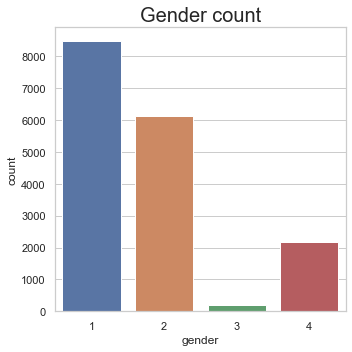

In [141]:
fig = plt.figure(figsize=(5,5))
sns.countplot(data=final_df, x='gender')
plt.title('Gender count', fontsize=20)
plt.tight_layout()
plt.savefig('gender_cnt.png', dpi=100)

#### gender and age

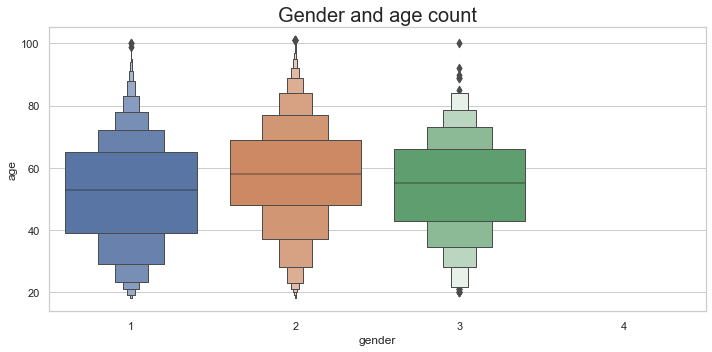

In [142]:
fig = plt.figure(figsize=(10,5))
sns.boxenplot(data=final_df, y="age", x="gender")
plt.title('Gender and age count', fontsize=20)
plt.tight_layout()
plt.savefig('gender_age_cnt.png', dpi=100)

mid 50 percentile of female customers are slight older than other genders

#### gender and income

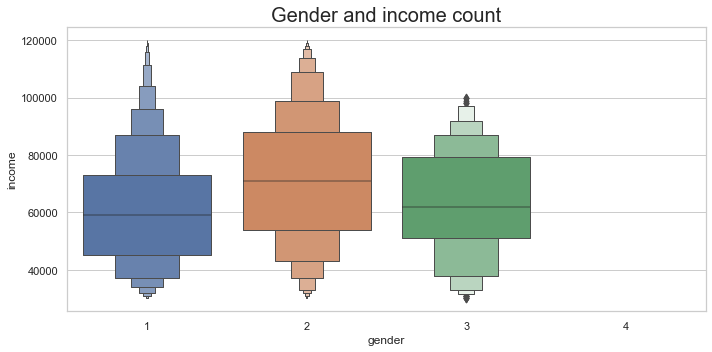

In [145]:
fig = plt.figure(figsize=(10,5))
sns.boxenplot(data=final_df, y="income", x="gender")
plt.title('Gender and income count', fontsize=20)
plt.tight_layout()
plt.savefig('gender_income_cnt.png', dpi=100)

female customers have higher income than others 

#### age 

In [63]:
final_df['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

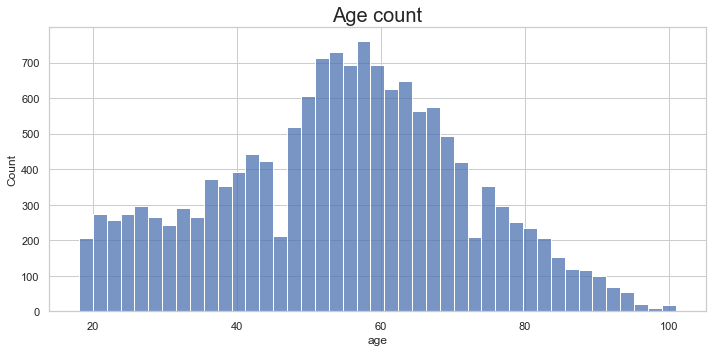

In [143]:
#final_df['age'].hist(bins=20)
fig = plt.figure(figsize=(10,5))
sns.histplot(data=final_df, x='age')
plt.title('Age count', fontsize=20)
plt.tight_layout()
plt.savefig('age_cnt.png', dpi=100)

the distribution of age is bell shaped, and the peak is at around age 55.

#### income

In [65]:
final_df['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

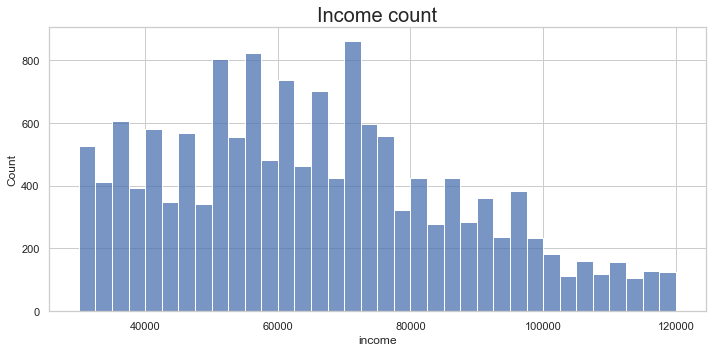

In [144]:
#final_df['income'].hist(bins=20)
fig = plt.figure(figsize=(10,5))
sns.histplot(data=final_df, x='income')
plt.title('Income count', fontsize=20)
plt.tight_layout()
plt.savefig('income_cnt.png', dpi=100)

income of mid 50 percentile is between 49000 and 80000 

#### income and age

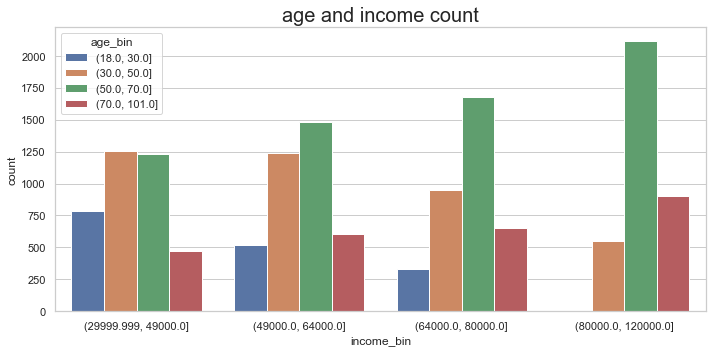

In [147]:
g = final_df.groupby(['age_bin','income_bin']).size().to_frame(name='count').reset_index()

fig = plt.figure(figsize=(10,5))
sns.barplot(data=g, x='income_bin', y='count', hue='age_bin')
plt.title('age and income count', fontsize=20)
plt.tight_layout()
plt.savefig('age_income_cnt', dpi=100)

#### enrollment count by year

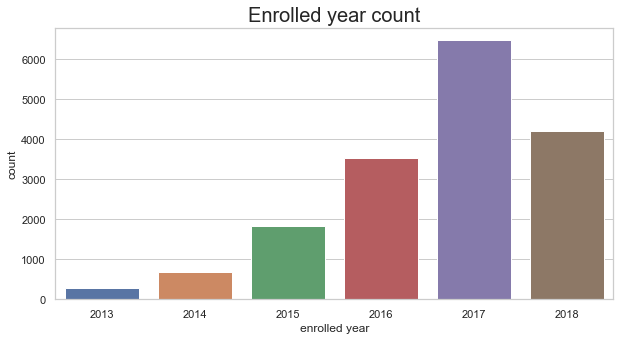

In [93]:
fig = plt.figure(figsize=(10,5))

sns.countplot(data = final_df, x='enrolled year')
plt.title('Enrolled year count', fontsize=20)
plt.savefig('enrolledyear_cnt', dpi=100)

In [94]:
final_df['enrolled year'].value_counts(normalize=True).sort_index()

2013    0.016824
2014    0.040647
2015    0.107647
2016    0.207412
2017    0.380529
2018    0.246941
Name: enrolled year, dtype: float64

among all members, 38% enrolled in year 2017. since this data only contains information up to July 26th, 2018, so the data of 2018 is incomplete.

### 2. money spent

#### distribution of amount of each transaction

In [95]:
transcript[transcript['event'].str.contains('trans')]['amount'].describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

50% of the transactions are below 9 dollars, and maximum amount is 1062 dollars

In [148]:
offer_dict = {'offer_id': portfolio['offer_id'].unique()
             ,'offer_type_c':['bogo', 'discount']
             ,'offer_type':['bogo', 'discount', 'informational']}

def draw(offer_key, groupby, column, title, filename=None):
    g_list = []
    for i in offer_dict[offer_key]:
        g = final_df.groupby([groupby])['%s_%s'%(column,i)].mean().to_frame('c')
        g_list.append(g)
    
    g_group = pd.concat(g_list, keys=offer_dict[offer_key]).reset_index().rename(columns={'level_0':offer_key})
    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(x=offer_key, y='c', hue=groupby, data=g_group)
    plt.title(title, fontsize=20)
    plt.ylabel('')
    plt.tight_layout()
    if filename!=None:
        plt.savefig(filename, dpi=100)

#### total money spent by gender by offer_type

In [97]:
portfolio

,reward,difficulty,offer_type,offer_id,channels_email,channels_mobile,channels_social,channels_web,duration_h
0,5,5,bogo,b0,1,1,1,1,120
1,10,10,bogo,b1,1,1,1,1,120
2,5,5,bogo,b2,1,1,0,1,168
3,10,10,bogo,b3,1,1,1,0,168
4,3,7,discount,d4,1,1,1,1,168
5,2,10,discount,d5,1,1,0,1,168
6,2,10,discount,d6,1,1,1,1,240
7,5,20,discount,d7,1,0,0,1,240
8,0,0,informational,i8,1,1,1,0,72
9,0,0,informational,i9,1,1,0,1,96


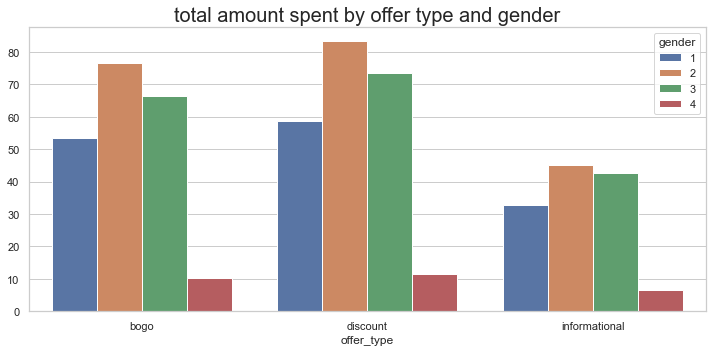

In [149]:
draw(offer_key='offer_type', 
     groupby='gender', 
     column='mamt_sum', 
     title='total amount spent by offer type and gender',
     filename='mamt_by_type_gender.png')

#### total money spent by gender by offer_id

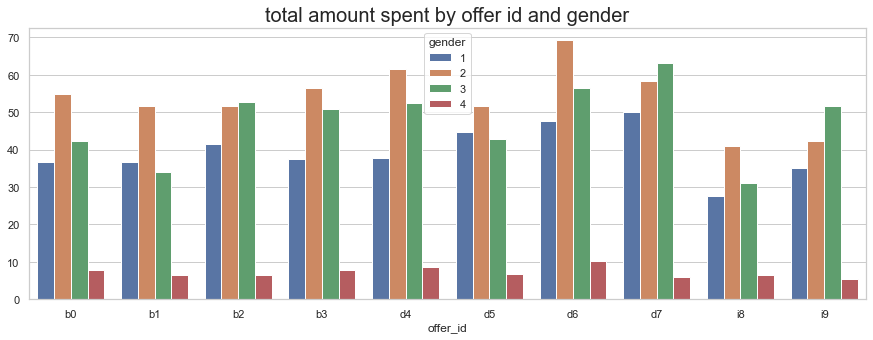

In [103]:
draw(offer_key='offer_id', 
     groupby='gender', 
     column='mamt_sum', 
     title='total amount spent by offer id and gender',
     filename='mamt_by_id_gender.png')

#### total money spent by age group by offer type

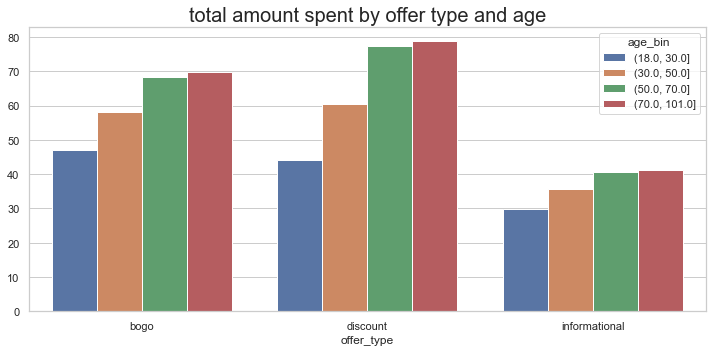

In [150]:
draw(offer_key='offer_type', 
     groupby='age_bin', 
     column='mamt_sum', 
     title='total amount spent by offer type and age',
     filename='mamt_by_type_age.png')

#### total money spent by age group by offer id

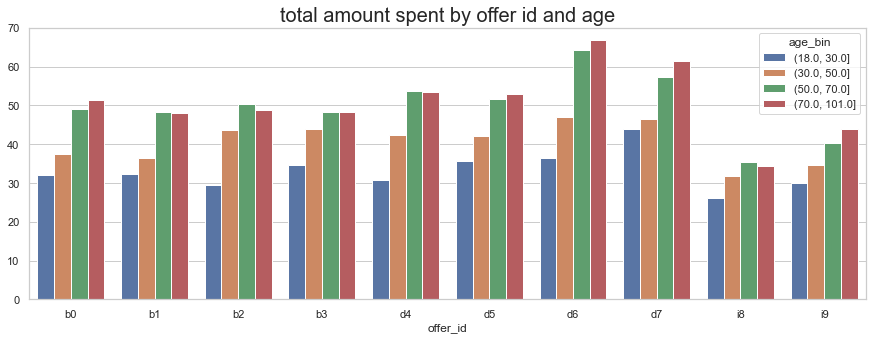

In [105]:
draw(offer_key='offer_id', 
     groupby='age_bin', 
     column='mamt_sum', 
     title='total amount spent by offer id and age',
     filename='mamt_by_id_age.png')

#### total money spent by income group by offer type

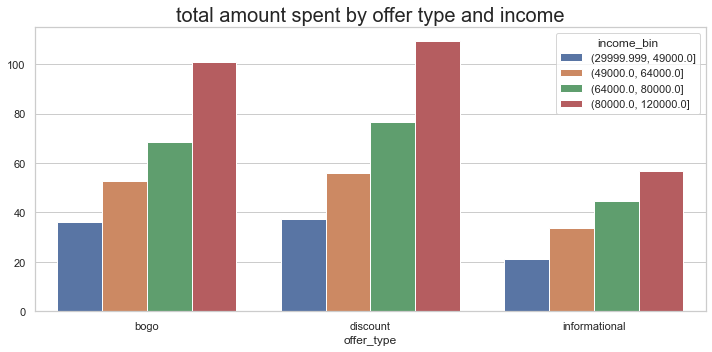

In [151]:
draw(offer_key='offer_type', 
     groupby='income_bin', 
     column='mamt_sum', 
     title='total amount spent by offer type and income',
     filename='mamt_by_type_income.png')

#### total money spent by income group by offer id

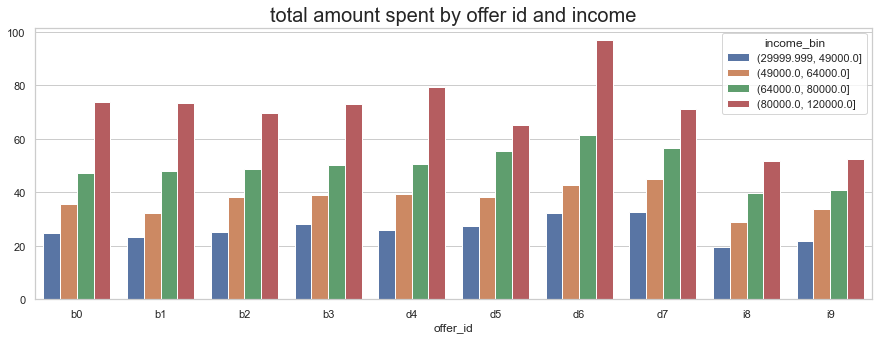

In [107]:
draw(offer_key='offer_id', 
     groupby='income_bin', 
     column='mamt_sum', 
     title='total amount spent by offer id and income')

### 3. offers

#### Which type of offers were received most

In [108]:
final_df[['cnt_receive_bogo','cnt_receive_discount','cnt_receive_informational']].sum()

cnt_receive_bogo             30499.0
cnt_receive_discount         30543.0
cnt_receive_informational    15235.0
dtype: float64

Starbucks have sent nearly equal number of discount and bogo offers to customers in this dataset, and the number of informational offers is only half of that of bogo or discount

Customers of all genders have received about 2 bogo, 2 discount, and 1 informational offer on average, and there is not much difference among genders

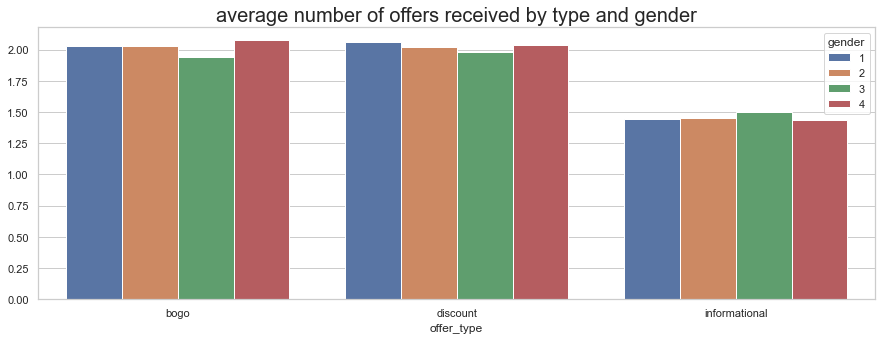

In [90]:
draw(offer_key='offer_type', 
     groupby='gender', 
     column='cnt_receive', 
     title='average number of offers received by type and gender')

#### Average time to complete each offer type by gender

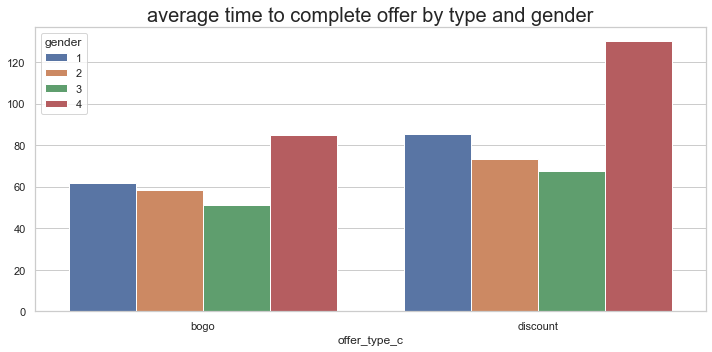

In [153]:
draw(offer_key='offer_type_c', groupby='gender', column='receive_complete_diff_mean', 
     title='average time to complete offer by type and gender', filename='time_complete_by_type_gender')

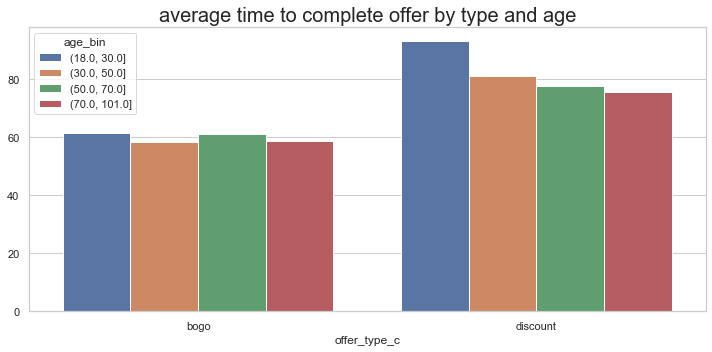

In [154]:
draw(offer_key='offer_type_c', groupby='age_bin', column='receive_complete_diff_mean', 
     title='average time to complete offer by type and age', filename='time_complete_by_type_age')

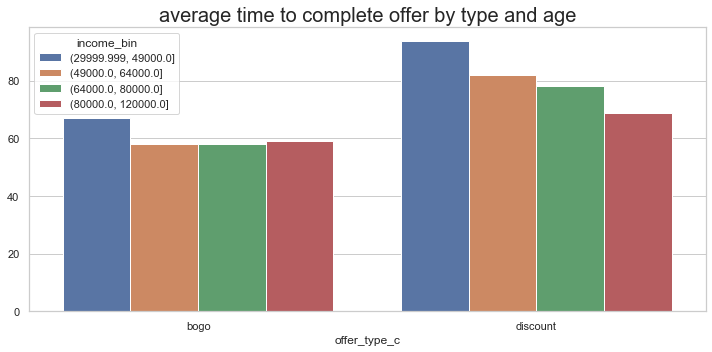

In [155]:
draw(offer_key='offer_type_c', groupby='income_bin', column='receive_complete_diff_mean', 
     title='average time to complete offer by type and age', filename='time_complete_by_type_age')

#### Average time to complete each offer id by gender

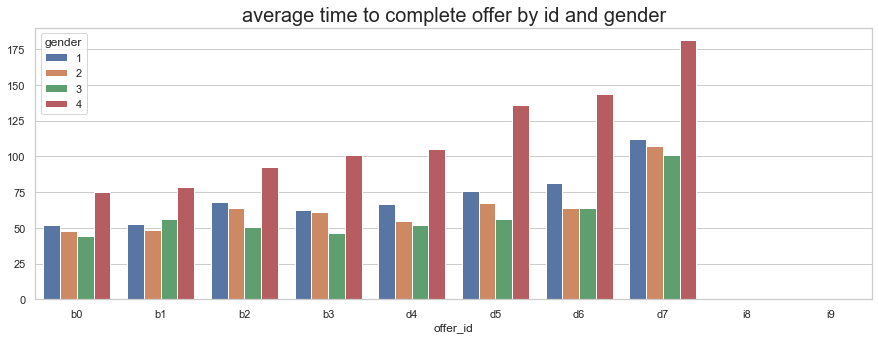

In [92]:
draw(offer_key='offer_id', groupby='gender', column='receive_complete_diff_mean', 
     title='average time to complete offer by id and gender')

it takes longest time to complete offer 5, and customers of other gender generally completed offers faster than others, and mysterious customers completed offers slowest.

#### offer view rate by gender and type

In [159]:
def draw_pct(offer_key, groupby, numerator, denominator, title, filename=None):
    g_list = []
    for i in offer_dict[offer_key]:
        numerator_cnt = final_df.groupby(groupby)['cnt_%s_%s'%(numerator, i)].sum()
        denominator_cnt = final_df.groupby(groupby)['cnt_%s_%s'%(denominator, i)].sum()

        g = (numerator_cnt / denominator_cnt).to_frame(name='pct_%s/%s'%(numerator, denominator))
        g_list.append(g)

    g_df = pd.concat(g_list, keys=offer_dict[offer_key]).reset_index().rename(columns={'level_0':offer_key})


    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(data=g_df, hue=groupby, y='pct_%s/%s'%(numerator, denominator),x=offer_key)
    plt.title(title, fontsize=20)
    plt.tight_layout()
    if filename!=None:
        plt.savefig(filename, dpi=100)

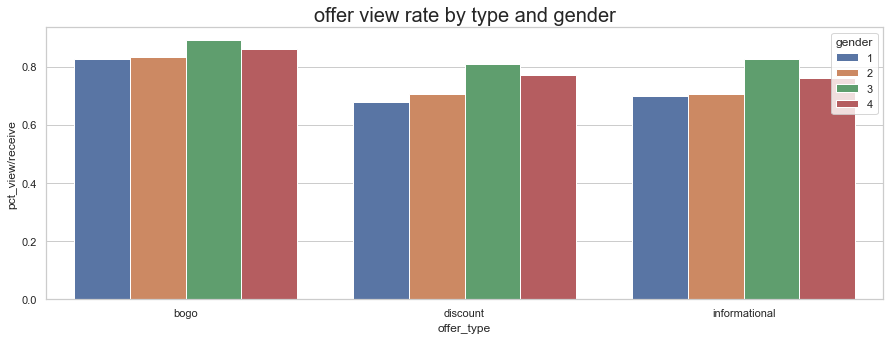

In [94]:
draw_pct(offer_key='offer_type', groupby='gender', numerator='view', denominator='receive', title='offer view rate by type and gender')

the ranking of attractivenees is informational, bogo, discount and for all genders, and customers of other gender have higher offer view rate for all type of offers.

#### offer view rate by gender and offer_id

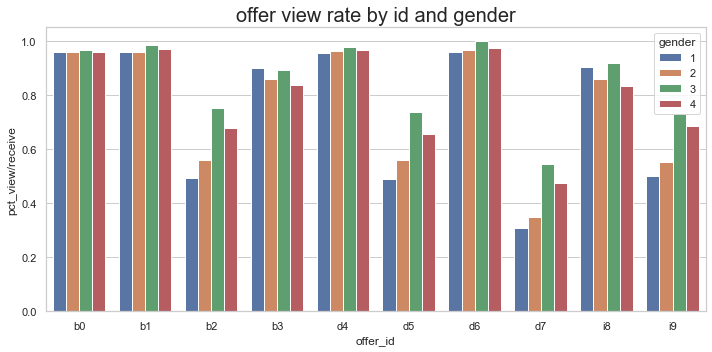

In [160]:
draw_pct(offer_key='offer_id', groupby='gender', numerator='view', denominator='receive', title='offer view rate by id and gender',
        filename='view_rate_by_id_gender')

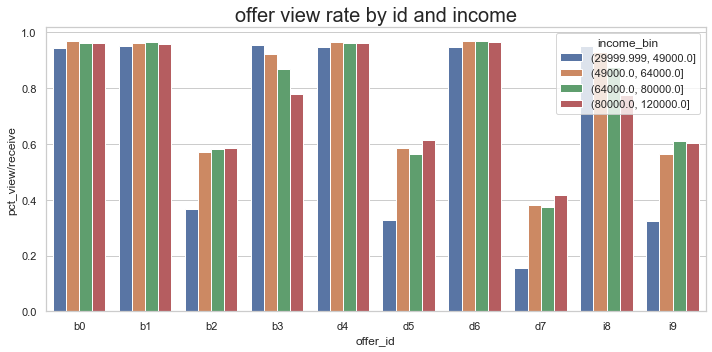

In [162]:
draw_pct(offer_key='offer_id', groupby='income_bin', numerator='view', denominator='receive', title='offer view rate by id and income',
        filename='view_rate_by_id_income')

#### offer view rate by type and age

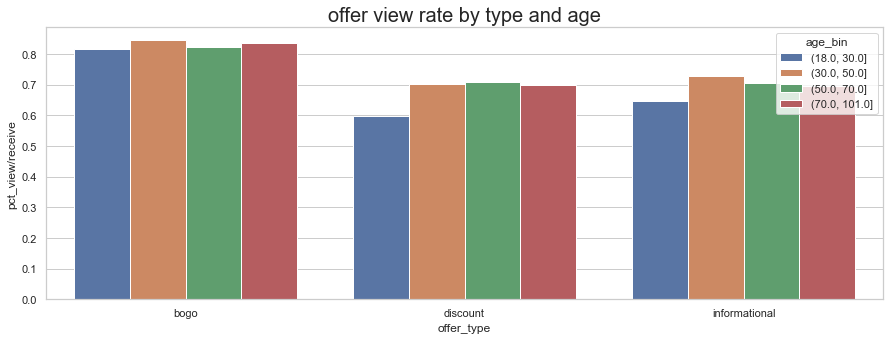

In [96]:
draw_pct(offer_key='offer_type', groupby='age_bin', numerator='view', denominator='receive', title='offer view rate by type and age')

#### offer view rate by id and age

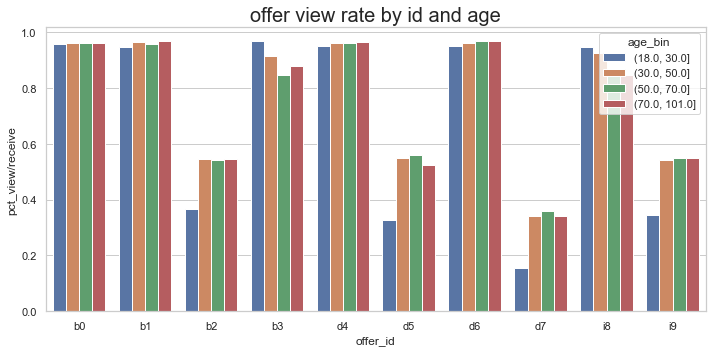

In [161]:
draw_pct(offer_key='offer_id', groupby='age_bin', numerator='view', denominator='receive', title='offer view rate by id and age',
        filename='view_rate_by_id_age')

#### offer view rate by type and income

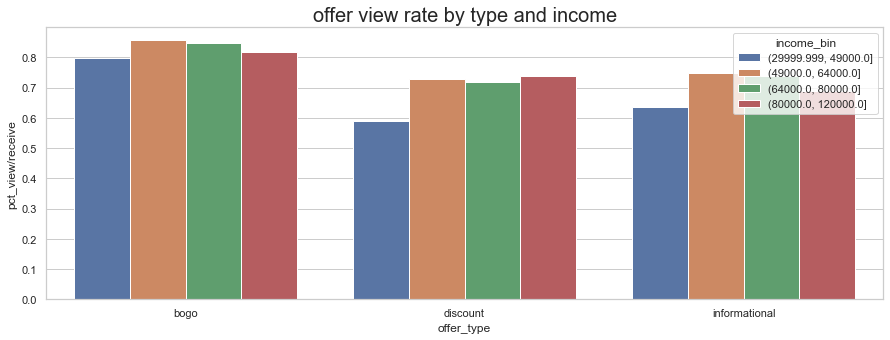

In [98]:
draw_pct(offer_key='offer_type', groupby='income_bin', numerator='view', denominator='receive', title='offer view rate by type and income')

#### offer view rate by id and income

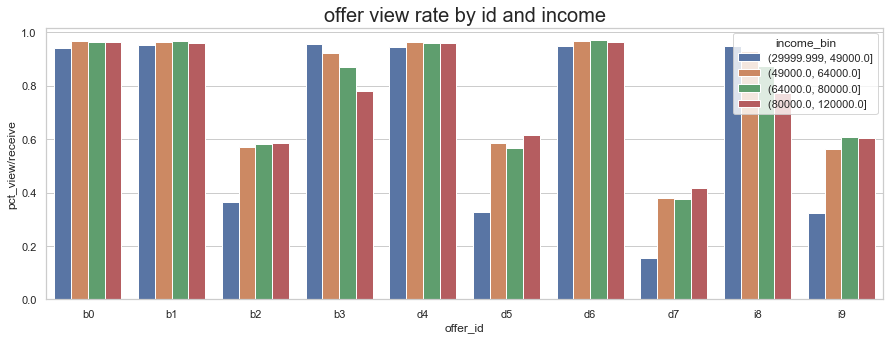

In [99]:
draw_pct(offer_key='offer_id', groupby='income_bin', numerator='view', denominator='receive', title='offer view rate by id and income')

#### offer completion rate by gender and type

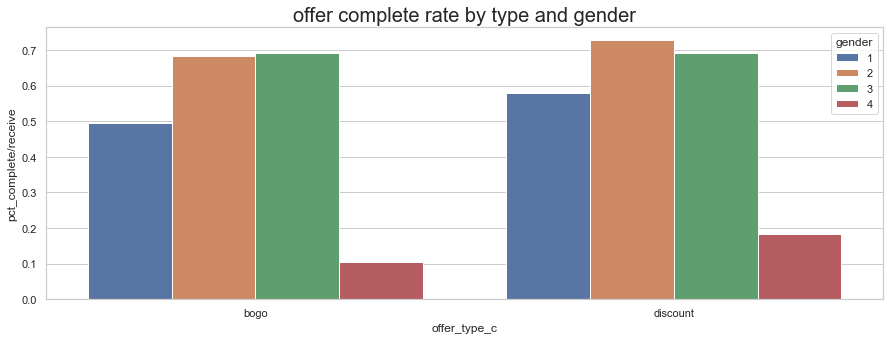

In [100]:
draw_pct(offer_key='offer_type_c', groupby='gender', numerator='complete', denominator='receive', 
         title='offer complete rate by type and gender')

completion rate distribution of bogo and discount is similar, and the rate of discount is slightly higher than bogo for male, female, and unknown gender customers

#### offer completion rate by gender and offer_id

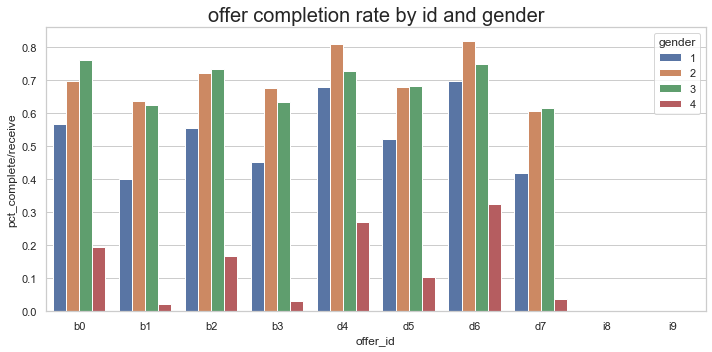

In [164]:
draw_pct(offer_key='offer_id', groupby='gender', numerator='complete', denominator='receive', 
         title='offer completion rate by id and gender', filename='complete_rate_id_gender')

complete rate of mysterious customers are lowest

#### offer completion rate by type and age

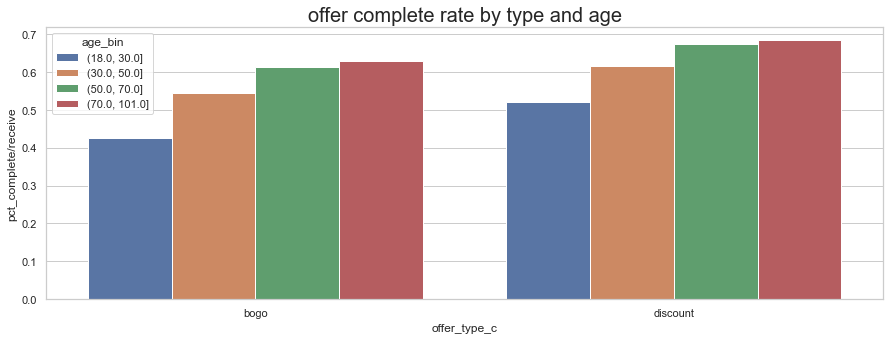

In [102]:
draw_pct(offer_key='offer_type_c', groupby='age_bin', numerator='complete', denominator='receive', 
         title='offer complete rate by type and age')

#### offer completion rate by id and age

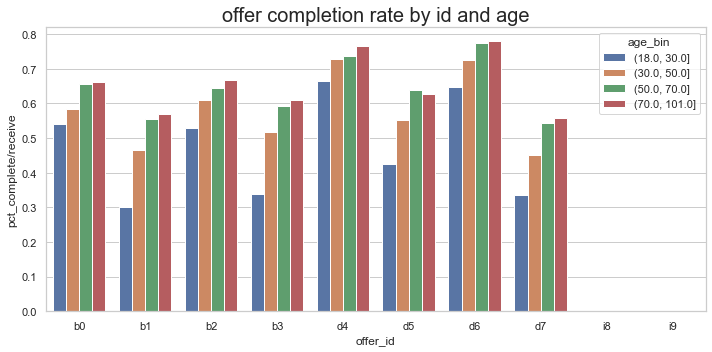

In [166]:
draw_pct(offer_key='offer_id', groupby='age_bin', numerator='complete', denominator='receive', 
         title='offer completion rate by id and age', filename='complete_rate_by_id_age')

#### offer completion rate by type and income

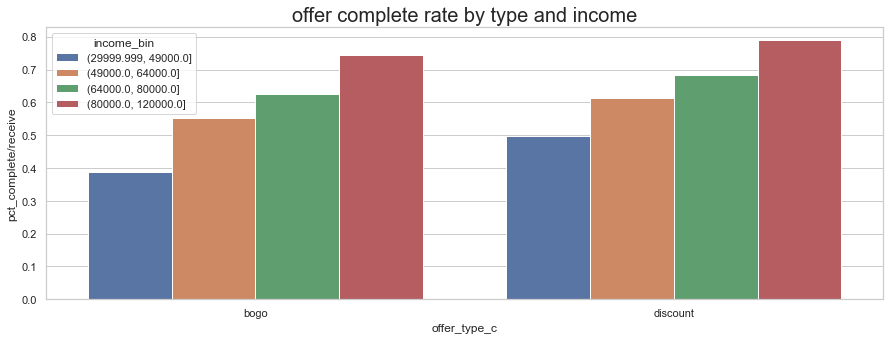

In [104]:
draw_pct(offer_key='offer_type_c', groupby='income_bin', numerator='complete', denominator='receive', 
         title='offer complete rate by type and income')

#### offer completion rate by id and income

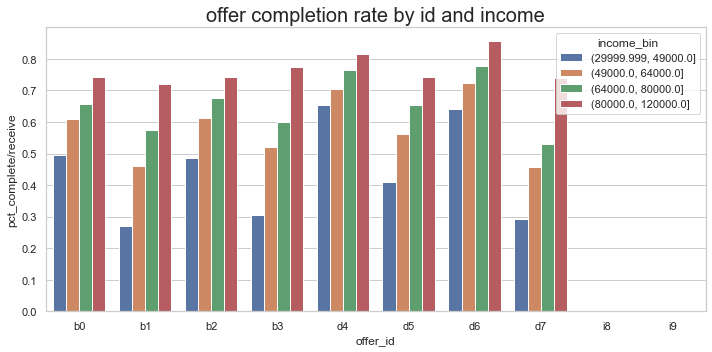

In [167]:
draw_pct(offer_key='offer_id', groupby='income_bin', numerator='complete', denominator='receive', 
         title='offer completion rate by id and income', filename='complete_rate_by_id_income.png')

#### complete without view rate

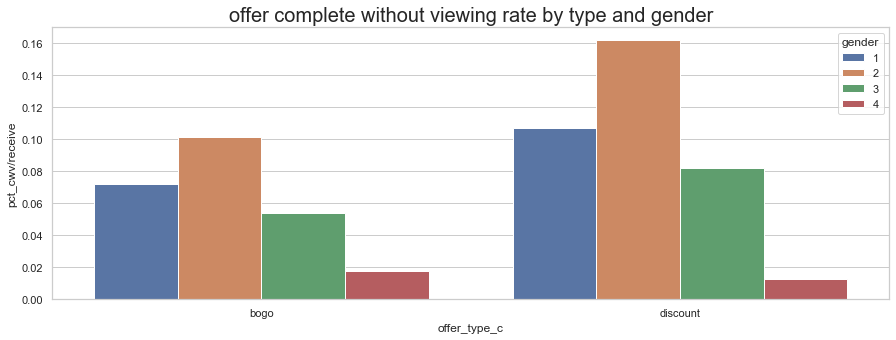

In [106]:
draw_pct(offer_key='offer_type_c', groupby='gender', numerator='cwv', denominator='receive', 
         title='offer complete without viewing rate by type and gender')

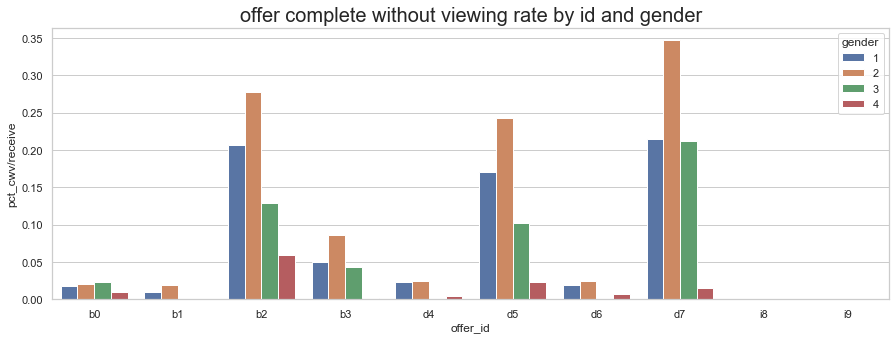

In [107]:
draw_pct(offer_key='offer_id', groupby='gender', numerator='cwv', denominator='receive', 
         title='offer complete without viewing rate by id and gender')

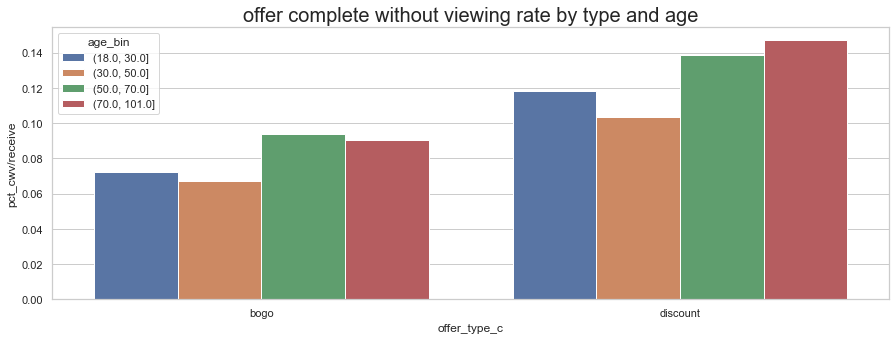

In [108]:
draw_pct(offer_key='offer_type_c', groupby='age_bin', numerator='cwv', denominator='receive', 
         title='offer complete without viewing rate by type and age')

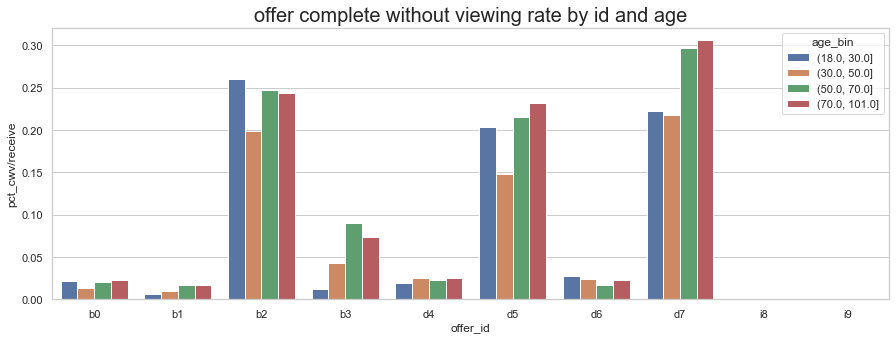

In [109]:
draw_pct(offer_key='offer_id', groupby='age_bin', numerator='cwv', denominator='receive', 
         title='offer complete without viewing rate by id and age')

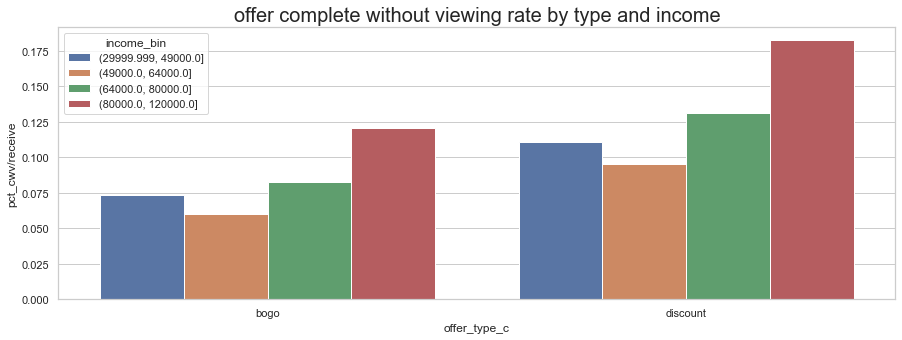

In [110]:
draw_pct(offer_key='offer_type_c', groupby='income_bin', numerator='cwv', denominator='receive', 
         title='offer complete without viewing rate by type and income')

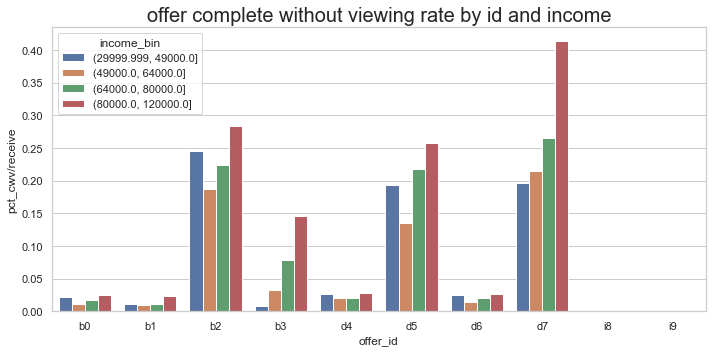

In [168]:
draw_pct(offer_key='offer_id', groupby='income_bin', numerator='cwv', denominator='receive', 
         title='offer complete without viewing rate by id and income', filename='complete_without_view_by_id_income')

#### offer viewed after completing rate

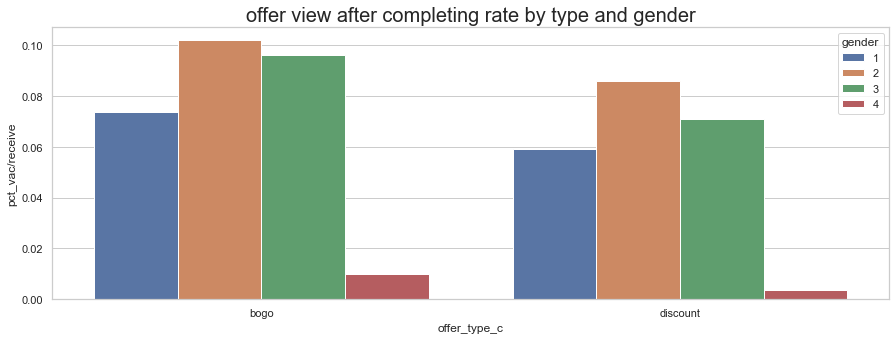

In [112]:
draw_pct(offer_key='offer_type_c', groupby='gender', numerator='vac', denominator='receive', 
         title='offer view after completing rate by type and gender')

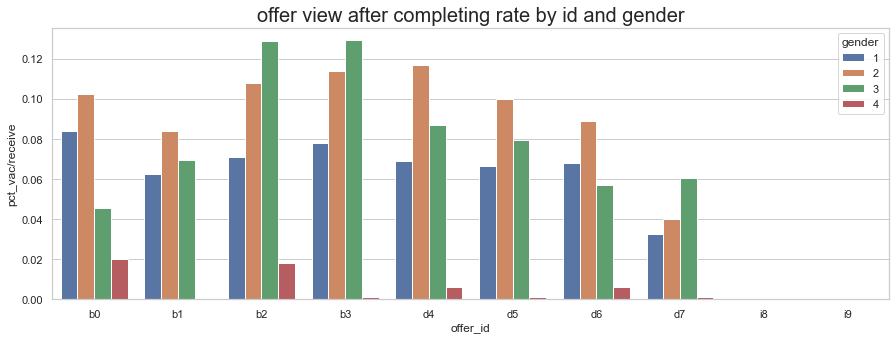

In [113]:
draw_pct(offer_key='offer_id', groupby='gender', numerator='vac', denominator='receive', 
         title='offer view after completing rate by id and gender')

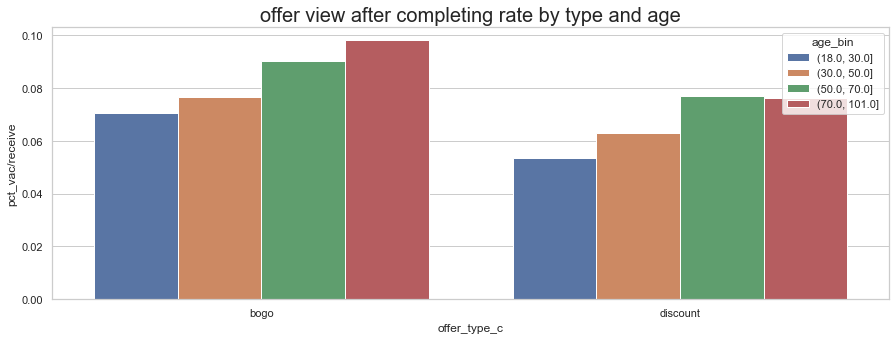

In [114]:
draw_pct(offer_key='offer_type_c', groupby='age_bin', numerator='vac', denominator='receive', 
         title='offer view after completing rate by type and age')

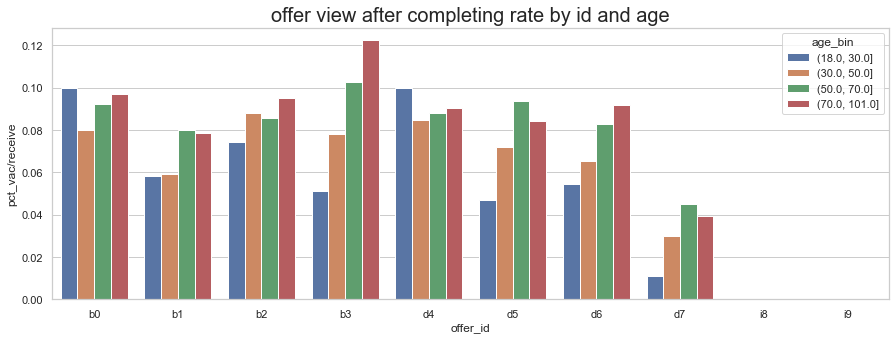

In [115]:
draw_pct(offer_key='offer_id', groupby='age_bin', numerator='vac', denominator='receive', 
         title='offer view after completing rate by id and age')

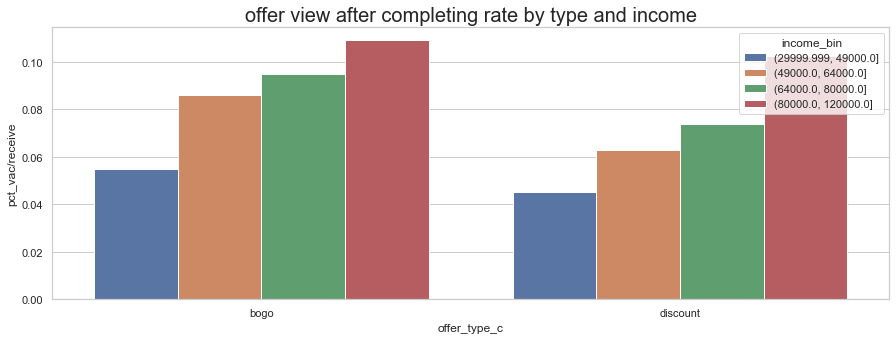

In [116]:
draw_pct(offer_key='offer_type_c', groupby='income_bin', numerator='vac', denominator='receive', 
         title='offer view after completing rate by type and income')

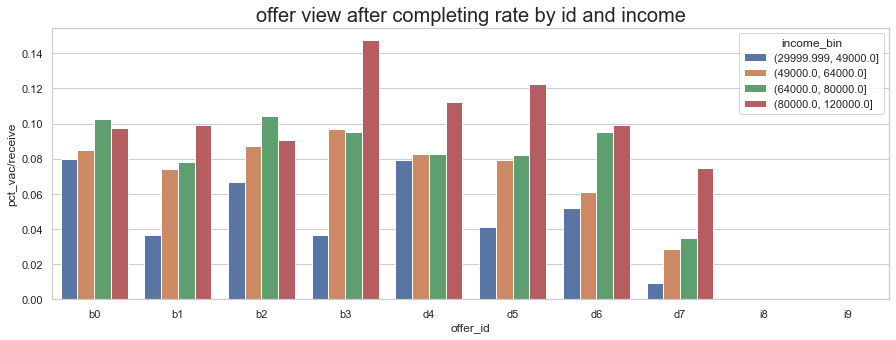

In [117]:
draw_pct(offer_key='offer_id', groupby='income_bin', numerator='vac', denominator='receive', 
         title='offer view after completing rate by id and income')

#### completion rate

In [120]:
transcript[transcript['event'].str.contains('comp')]['offer_id'].value_counts(dropna=False, normalize=True)

d6    0.158343
d4    0.153548
b2    0.129664
b0    0.127937
d5    0.119628
b3    0.109831
d7    0.101849
b1    0.099199
Name: offer_id, dtype: float64

# Model

#### The offer with highest completion rate will be the one for the customer

#### I will try different algorithms, starting with the simple ones such as Naive Bayes and Decision Tree, and then try ensemble algorithms such as Random Forest and CatBoost.

In [132]:
from sklearn.model_selection import train_test_split as TTS
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve, accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
#from dtreeviz.models.shadow_decision_tree import ShadowDecTree
#from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree
#from dtreeviz import trees

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

final_df = pd.read_csv('final_df.csv', index_col=0)
final_df.head()

,cnt_receive_total,cnt_receive_bogo,cnt_receive_discount,cnt_receive_informational,cnt_receive_email,cnt_receive_mobile,cnt_receive_social,cnt_receive_web,cnt_receive_b0,cnt_receive_d5,cnt_receive_d6,cnt_receive_i8,cnt_receive_i9,cnt_receive_b2,cnt_receive_d4,cnt_receive_d7,cnt_receive_b1,cnt_receive_b3,cnt_view_total,cnt_view_bogo,cnt_view_discount,cnt_view_informational,cnt_view_email,cnt_view_mobile,cnt_view_social,cnt_view_web,cnt_view_b0,cnt_view_d5,cnt_view_d6,cnt_view_i8,cnt_view_i9,cnt_view_b2,cnt_view_d4,cnt_view_d7,cnt_view_b1,cnt_view_b3,cnt_complete_total,cnt_complete_bogo,cnt_complete_discount,cnt_complete_informational,cnt_complete_email,cnt_complete_mobile,cnt_complete_social,cnt_complete_web,cnt_complete_b0,cnt_complete_d5,cnt_complete_d6,cnt_complete_i8,cnt_complete_i9,cnt_complete_b2,cnt_complete_d4,cnt_complete_d7,cnt_complete_b1,cnt_complete_b3,cnt_cwv_total,cnt_cwv_bogo,cnt_cwv_discount,cnt_cwv_informational,cnt_cwv_email,cnt_cwv_mobile,cnt_cwv_social,cnt_cwv_web,cnt_cwv_b0,cnt_cwv_d5,cnt_cwv_d6,cnt_cwv_i8,cnt_cwv_i9,cnt_cwv_b2,cnt_cwv_d4,cnt_cwv_d7,cnt_cwv_b1,cnt_cwv_b3,cnt_vac_total,cnt_vac_bogo,cnt_vac_discount,cnt_vac_informational,cnt_vac_email,cnt_vac_mobile,cnt_vac_social,cnt_vac_web,cnt_vac_b0,cnt_vac_d5,cnt_vac_d6,cnt_vac_i8,cnt_vac_i9,cnt_vac_b2,cnt_vac_d4,cnt_vac_d7,cnt_vac_b1,cnt_vac_b3,pct_view/receive_total,pct_view/receive_bogo,pct_view/receive_discount,pct_view/receive_informational,pct_view/receive_email,pct_view/receive_mobile,pct_view/receive_social,pct_view/receive_web,pct_view/receive_b0,pct_view/receive_d5,pct_view/receive_d6,pct_view/receive_i8,pct_view/receive_i9,pct_view/receive_b2,pct_view/receive_d4,pct_view/receive_d7,pct_view/receive_b1,pct_view/receive_b3,pct_complete/receive_total,pct_complete/receive_bogo,pct_complete/receive_discount,pct_complete/receive_informational,pct_complete/receive_email,pct_complete/receive_mobile,pct_complete/receive_social,pct_complete/receive_web,pct_complete/receive_b0,pct_complete/receive_d5,pct_complete/receive_d6,pct_complete/receive_i8,pct_complete/receive_i9,pct_complete/receive_b2,pct_complete/receive_d4,pct_complete/receive_d7,pct_complete/receive_b1,pct_complete/receive_b3,pct_cwv/complete_total,pct_cwv/complete_bogo,pct_cwv/complete_discount,pct_cwv/complete_informational,pct_cwv/complete_email,pct_cwv/complete_mobile,pct_cwv/complete_social,pct_cwv/complete_web,pct_cwv/complete_b0,pct_cwv/complete_d5,pct_cwv/complete_d6,pct_cwv/complete_i8,pct_cwv/complete_i9,pct_cwv/complete_b2,pct_cwv/complete_d4,pct_cwv/complete_d7,pct_cwv/complete_b1,pct_cwv/complete_b3,pct_vac/view_total,pct_vac/view_bogo,pct_vac/view_discount,pct_vac/view_informational,pct_vac/view_email,pct_vac/view_mobile,pct_vac/view_social,pct_vac/view_web,pct_vac/view_b0,pct_vac/view_d5,pct_vac/view_d6,pct_vac/view_i8,pct_vac/view_i9,pct_vac/view_b2,pct_vac/view_d4,pct_vac/view_d7,pct_vac/view_b1,pct_vac/view_b3,receive_view_diff_max_total,receive_view_diff_min_total,receive_view_diff_mean_total,receive_view_diff_max_bogo,receive_view_diff_max_discount,receive_view_diff_max_informational,receive_view_diff_min_bogo,receive_view_diff_min_discount,receive_view_diff_min_informational,receive_view_diff_mean_bogo,receive_view_diff_mean_discount,receive_view_diff_mean_informational,receive_view_diff_max_email,receive_view_diff_min_email,receive_view_diff_mean_email,receive_view_diff_max_mobile,receive_view_diff_min_mobile,receive_view_diff_mean_mobile,receive_view_diff_max_social,receive_view_diff_min_social,receive_view_diff_mean_social,receive_view_diff_max_web,receive_view_diff_min_web,receive_view_diff_mean_web,receive_view_diff_max_b0,receive_view_diff_max_b1,receive_view_diff_max_b2,receive_view_diff_max_b3,receive_view_diff_max_d4,receive_view_diff_max_d5,receive_view_diff_max_d6,receive_view_diff_max_d7,receive_view_diff_max_i8,receive_view_diff_max_i9,receive_view_diff_min_b0,receive_view_diff_min_b1,receive_view_diff_min_b2,receive_view_diff_min_b3,receive_view_diff_min_d

In [133]:
model_df = final_df.copy()
model_df = model_df.fillna(0)

model_df['target'] = model_df[['pct_complete/receive_b0',
                                 'pct_complete/receive_d5',
                                 'pct_complete/receive_d6',
                                 'pct_complete/receive_i8',
                                 'pct_complete/receive_i9',
                                 'pct_complete/receive_b2',
                                 'pct_complete/receive_d4',
                                 'pct_complete/receive_d7',
                                 'pct_complete/receive_b1',
                                 'pct_complete/receive_b3',]].idxmax(axis=1)

model_df['not_send'] = model_df[['cnt_receive_b0',
                                 'cnt_receive_d5',
                                 'cnt_receive_d6',
                                 'cnt_receive_i8',
                                 'cnt_receive_i9',
                                 'cnt_receive_b2',
                                 'cnt_receive_d4',
                                 'cnt_receive_d7',
                                 'cnt_receive_b1',
                                 'cnt_receive_b3']].idxmin(axis=1)

model_df['target'] = model_df['target'].fillna(model_df['not_send'])
model_df['target'] = model_df['target'].apply(lambda x: x.rsplit("_",maxsplit=1)[1])

complete_columns = model_df.loc[:, model_df.columns.str.contains('complete|cwv|vac')].columns.tolist()

number_df = model_df.select_dtypes(exclude=['object'])

X = number_df.drop(complete_columns, axis=1)
y = model_df['target']

X_train, X_test, y_train, y_test = TTS(X, y, test_size=.3)

Accuracy score: 0.49392156862745096


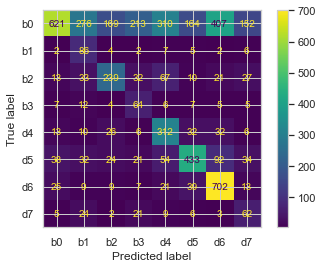

In [134]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB().fit(X_train, y_train)
print('Accuracy score:', clf.score(X_test, y_test))

plot_confusion_matrix(clf, X_test, y_test)

Accuracy score: 0.7496078431372549


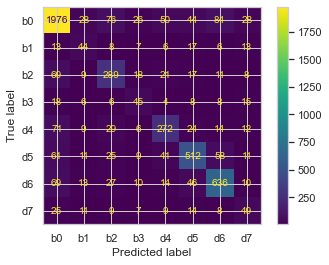

In [135]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy score:', clf.score(X_test, y_test))

plot_confusion_matrix(clf, X_test, y_test)

Accuracy score: 0.8141176470588235


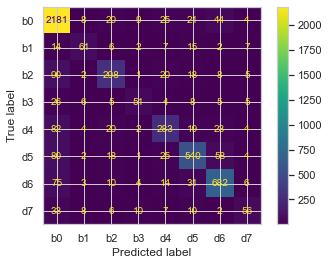

In [136]:
clf = RandomForestClassifier().fit(X_train, y_train)
print('Accuracy score:', clf.score(X_test, y_test))

plot_confusion_matrix(clf, X_test, y_test)

Accuracy score: 0.8337254901960784
CPU times: user 2min 53s, sys: 1.15 s, total: 2min 54s
Wall time: 2min 56s


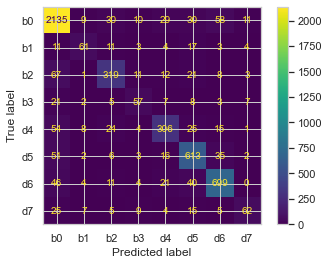

In [137]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier().fit(X_train, y_train)
print('Accuracy score:', clf.score(X_test, y_test))

plot_confusion_matrix(clf, X_test, y_test)

In [173]:
pd.Series(data=clf.feature_importances_, index=X.columns).sort_values(ascending=False)[:20]

cnt_receive_b0                0.152559
mamt_sum_d6                   0.129547
mamt_sum_d5                   0.068698
mamt_sum_total                0.066551
mamt_max_b0                   0.061774
cnt_receive_d5                0.060139
mamt_sum_web                  0.055819
mamt_sum_email                0.046824
mamt_sum_d4                   0.038135
cnt_receive_b2                0.027687
mamt_max_d5                   0.026000
mamt_sum_mobile               0.024502
mamt_sum_discount             0.023057
mamt_max_b2                   0.021153
view_trans_hrs_diff_min_b0    0.018007
cnt_receive_d6                0.014823
mamt_mean_b0                  0.011248
mamt_max_mobile               0.008172
mamt_min_b0                   0.007029
mamt_max_web                  0.005888
dtype: float64

The most important features are 
- number of offers received
- amount of money spent after receiving offers
- time between viewing offers and making transactions

In [174]:
import pickle
pkl_filename = "starbucks_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)